In [72]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import time
import math

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch.utils.data
from torch.autograd import Variable #自動微分用
import numpy as np

import matplotlib
#matplotlib.use("Agg")
import matplotlib.pyplot as plt

In [73]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [74]:
import pickle
emoji_index = pickle.loads(open('./emoji_index.pkl', 'rb').read())
def emojiFromIndex(num):
    return [k for k, v in emoji_index.items() if v == num]

emojiFromIndex(10)

['💦']

In [75]:
from sklearn.model_selection import train_test_split
import collections

class pytorchloader:
    def __init__(self, dataPath='./text_label_split.tsv'):
        # ベクトルの読み込み
        self.lines = open(dataPath, encoding='utf-8').read().strip().split('\n')
        self.pairs = [[s for s in l.split('\t')] for l in self.lines]
        self.labels = [p[1] for p in self.pairs]
        # データ作成
        self.out_pairs = []
        self.out_labels = []

    def normalize(self):
        # データ数を合わせる
        c = collections.Counter(self.labels)
        sample_nums = c.most_common()
        print("sample_nums:", sample_nums)

        min_num = np.min([s[1] for s in sample_nums])
        print("min_num:", min_num)

        for sample in sample_nums:
            diff_num = int(sample[1] - min_num)
            print("クラス%s 削除サンプル数: %d (%0.2f％)" % (sample[0], diff_num, (diff_num/sample[1])*100))
            indexes = [i for i, l in enumerate(self.labels) if l == sample[0]]
            del_indexes = random.sample(indexes, min_num)
            self.out_pairs.extend([self.pairs[i] for i in indexes])
            self.out_labels.extend([self.labels[i] for i in indexes])

    def label_count(self):
        return len(collections.Counter([str(v) for v in self.labels]))
    
    def rawdata(self):
        return self.pairs
    
    def split(self):
        X_train, X_test, y_train, y_test = train_test_split(self.out_pairs, self.labels, test_size=0.20, random_state=random.randint(0, 100))
        return X_train, X_test

In [76]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [77]:
import csv
def readLangs(lang1, lang2, fn, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open(fn, encoding='utf-8').read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[s for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [78]:
MAX_LENGTH = 31

In [79]:
def prepareData(lang1, lang2, fn, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, fn, reverse)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [80]:
def prepareData2(lang1, lang2, fn):
    loader = pytorchloader(fn)
    loader.normalize()
    pairs, pairs_test = loader.split()
    input_lang, output_lang = Lang(lang1), Lang(lang2)
    print("Read %s sentence pairs" % len(pairs))
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs, pairs_test

In [81]:
input_lang, output_lang, pairs, pairs_test = prepareData2('in', 'out', 'text_label_split_10class.tsv')
print(random.choice(pairs))

#input_lang, output_lang, pairs = prepareData('in', 'out', 'text_label_split.tsv', False)
#print(random.choice(pairs_test))

sample_nums: [('2', 53592), ('10', 38038), ('9', 26034), ('1', 22109), ('4', 17432), ('5', 16174), ('7', 13489), ('3', 10927), ('6', 10851), ('8', 9534)]
min_num: 9534
クラス2 削除サンプル数: 44058 (82.21％)
クラス10 削除サンプル数: 28504 (74.94％)
クラス9 削除サンプル数: 16500 (63.38％)
クラス1 削除サンプル数: 12575 (56.88％)
クラス4 削除サンプル数: 7898 (45.31％)
クラス5 削除サンプル数: 6640 (41.05％)
クラス7 削除サンプル数: 3955 (29.32％)
クラス3 削除サンプル数: 1393 (12.75％)
クラス6 削除サンプル数: 1317 (12.14％)
クラス8 削除サンプル数: 0 (0.00％)
Read 174544 sentence pairs
Trimmed to 174544 sentence pairs
Counting words...
Counted words:
in 57185
out 12
['高価 な 誕 プレﾟ Д ﾟｽｹﾞｪ ', '9']


In [82]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [83]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hiddenｋ

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [84]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0), encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [85]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ') if word in lang.word2index]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [86]:
teacher_forcing_ratio = 0.5

In [87]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0
    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [88]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [89]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses, "losses.png")

In [90]:
import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np


def showPlot(points, filename):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.savefig(filename)
    plt.show()
    plt.close()

In [91]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd

def showConfusionMatrix(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    index = columns = [str(l) for l in range(len(emoji_index))]
    df = pd.DataFrame(conf_mat, index=index, columns=columns)
    
    fig = plt.figure(figsize = (7,7))
    sns.heatmap(df, annot=False, square=True, fmt='.0f', cmap="Blues")
    plt.title('20 emojis classification')
    plt.xlabel('emojis')
    plt.ylabel('prediction')
    fig.savefig("confusion_matrix_torch3.png")
    plt.show()
    plt.close()

In [92]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

In [93]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        print('original emoji = ', emojiFromIndex(int(pair[1])))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('output emoji < ', emojiFromIndex(int(output_words[0])))
        print('')

In [94]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score

def evaluateTestdata(encoder, decoder):
    y_test, y_pred = [], []
    for pair in pairs_test:
        y_test.append(int(pair[1]))
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        y_pred.append(int(output_words[0]))
    print("precision", precision_score(y_test, y_pred, average=None))
    print("report", classification_report(y_test, y_pred))
    print("accuracy score", accuracy_score(y_test, y_pred))
    showConfusionMatrix(y_test, y_pred)
    

In [95]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)

In [96]:
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

1m 11s (- 16m 39s) (5000 6%) 1.0275
2m 19s (- 15m 8s) (10000 13%) 0.8898
3m 28s (- 13m 53s) (15000 20%) 0.8518
4m 37s (- 12m 42s) (20000 26%) 0.8427
5m 46s (- 11m 32s) (25000 33%) 0.8135
6m 54s (- 10m 21s) (30000 40%) 0.8047
8m 2s (- 9m 11s) (35000 46%) 0.7822
9m 11s (- 8m 2s) (40000 53%) 0.7881
10m 19s (- 6m 52s) (45000 60%) 0.7777
11m 27s (- 5m 43s) (50000 66%) 0.7561
12m 35s (- 4m 34s) (55000 73%) 0.7513
13m 44s (- 3m 26s) (60000 80%) 0.7610
14m 52s (- 2m 17s) (65000 86%) 0.7536
16m 1s (- 1m 8s) (70000 93%) 0.7462
17m 9s (- 0m 0s) (75000 100%) 0.7319


<Figure size 432x288 with 0 Axes>

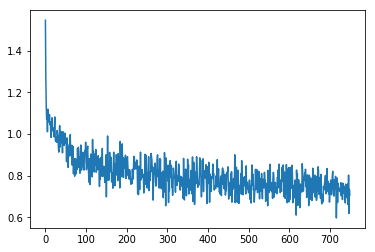

In [97]:
trainIters(encoder1, attn_decoder1, 75000, print_every=5000)

In [98]:
evaluateRandomly(encoder1, attn_decoder1)

> 『 아야어여오요우유으이 』 🇰🇷 ジェイ ケル 🇳🇿  さん の に 参加 しよう ラッシェル の お兄ちゃん だ よ 〜 〜 
= 7
original emoji =  ['😉']
< 2 <EOS>
output emoji <  ['😊']

> 大好き な 先生 と も 撮れ て 満足 
= 6
original emoji =  ['🙆']
< 2 <EOS>
output emoji <  ['😊']

> 入り たい 方 は リプ お願い し ます 
= 4
original emoji =  ['🙇']
< 4 <EOS>
output emoji <  ['🙇']

> 楽しかっ た ん です けど 自己満 な ので 大変 申し訳 ござい ませ ん でし た 
= 4
original emoji =  ['🙇']
< 4 <EOS>
output emoji <  ['🙇']

> 今日 は 、 リラックス し て ね 
= 7
original emoji =  ['😉']
< 2 <EOS>
output emoji <  ['😊']

> これ は ちょっと 寄り すぎ  ️
= 10
original emoji =  ['💦']
< 10 <EOS>
output emoji <  ['💦']

> でも 、 我が家 に は ミシン が ない ので 手縫い だ から 時間 かかる し 完成度 も イマイチ だ けど 、 時間 忘れ て 無心 に なれる から 楽しい 
= 2
original emoji =  ['😊']
< 2 <EOS>
output emoji <  ['😊']

> めっちゃ 好き です 〜 
= 2
original emoji =  ['😊']
< 1 <EOS>
output emoji <  ['😍']

> 私 の 手持ち から 出す ので 、 なかなか いい サジ ン が なく て すみません 
= 10
original emoji =  ['💦']
< 10 <EOS>
output emoji <  ['💦']

> ポスター 設置 し て 頂き ありがとう ござい ます 
= 2
original emoji =  ['😊']
< 2 <EOS>
output emoji <  ['

In [99]:
output_words, attentions = evaluate(
    encoder1, attn_decoder1, "仲良く し て")
plt.matshow(attentions.numpy())
plt.savefig('frendme.png')
plt.close()

In [100]:
def showAttention(input_sentence, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)
    ax.set_yticklabels([''] + output_words)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    #plt.show()
    plt.savefig('frendme.png')
    plt.close()

In [101]:
def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    print('output emoji = ', emojiFromIndex(int(output_words[0])))
    showAttention(input_sentence, output_words, attentions)

In [102]:
evaluateAndShowAttention("なお クン は 気圧 の 変化 に も 弱い から 、 いろいろ 心配 で あり やす 、 、 、")

input = なお クン は 気圧 の 変化 に も 弱い から 、 いろいろ 心配 で あり やす 、 、 、
output = 10 <EOS>
output emoji =  ['💦']


precision [0.57537601 0.40592372 0.51901026 0.51260206 0.45159351 0.44375
 0.57506053 0.75539988 0.74974908 0.51237113]
report              precision    recall  f1-score   support

          1       0.58      0.37      0.45      4470
          2       0.41      0.71      0.52     10711
          3       0.52      0.39      0.45      2178
          4       0.51      0.41      0.45      3546
          5       0.45      0.23      0.31      3217
          6       0.44      0.13      0.20      2159
          7       0.58      0.18      0.27      2675
          8       0.76      0.67      0.71      1927
          9       0.75      0.44      0.55      5101
         10       0.51      0.65      0.57      7652

avg / total       0.53      0.49      0.48     43636

accuracy score 0.4946374553121276


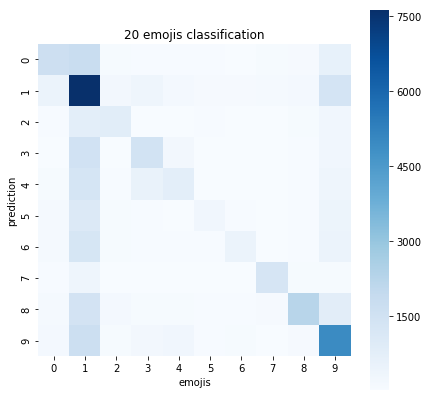

In [103]:
evaluateTestdata(encoder1, attn_decoder1)

In [104]:
plt.close('all')